In [1]:
import tensorflow as tf
import numpy as np
import colorsys
import tensorflow.keras.backend as K
from PIL import Image, ImageFont, ImageDraw
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv2D, Add, ZeroPadding2D, UpSampling2D, Concatenate, MaxPooling2D, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.regularizers import l2
from functools import reduce
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
def compose(*funcs):
    """Compose arbitrarily many functions, evaluated left to right.

    Reference: https://mathieularose.com/function-composition-in-python/
    """
    # return lambda x: reduce(lambda v, f: f(v), funcs, x)
    if funcs:
        return reduce(lambda f, g: lambda *a, **kw: g(f(*a, **kw)), funcs)
    else:
        raise ValueError('Composition of empty sequence not supported.')

In [4]:
def DarknetConv2D(*args, **kwargs):
    """Wrapper to set Darknet parameters for Convolution2D."""
    darknet_conv_kwargs = {'kernel_regularizer': l2(5e-4)}
    darknet_conv_kwargs['padding'] = 'valid' if kwargs.get('strides') == (2, 2) else 'same'
    darknet_conv_kwargs.update(kwargs)
    return Conv2D(*args, **darknet_conv_kwargs)

def DarknetConv2D_BN_Leaky(*args, **kwargs):
    """Darknet Convolution2D followed by BatchNormalization and LeakyReLU."""
    no_bias_kwargs = {'use_bias': False}
    no_bias_kwargs.update(kwargs)
    return compose(
        DarknetConv2D(*args, **no_bias_kwargs),
        BatchNormalization(),
        LeakyReLU(alpha=0.1))

def resblock_body(x, num_filters, num_blocks):
    '''A series of resblocks starting with a downsampling Convolution2D'''
    # Darknet uses left and top padding instead of 'same' mode
    x = ZeroPadding2D(((1, 0), (1, 0)))(x)
    x = DarknetConv2D_BN_Leaky(num_filters, (3, 3), strides=(2, 2))(x)
    for i in range(num_blocks):
        y = compose(
            DarknetConv2D_BN_Leaky(num_filters // 2, (1, 1)),
            DarknetConv2D_BN_Leaky(num_filters, (3, 3)))(x)
        x = Add()([x, y])
    return x

def darknet_body(x):
    '''Darknent body having 52 Convolution2D layers'''
    x = DarknetConv2D_BN_Leaky(32, (3, 3))(x)
    x = resblock_body(x, 64, 1)
    x = resblock_body(x, 128, 2)
    x = resblock_body(x, 256, 8)
    x = resblock_body(x, 512, 8)
    x = resblock_body(x, 1024, 4)
    return x

def make_last_layers(x, num_filters, out_filters):
    '''6 Conv2D_BN_Leaky layers followed by a Conv2D_linear layer'''
    x = compose(
        DarknetConv2D_BN_Leaky(num_filters, (1, 1)),
        DarknetConv2D_BN_Leaky(num_filters * 2, (3, 3)),
        DarknetConv2D_BN_Leaky(num_filters, (1, 1)),
        DarknetConv2D_BN_Leaky(num_filters * 2, (3, 3)),
        DarknetConv2D_BN_Leaky(num_filters, (1, 1)))(x)
    y = compose(
        DarknetConv2D_BN_Leaky(num_filters * 2, (3, 3)),
        DarknetConv2D(out_filters, (1, 1)))(x)
    return x, y

In [5]:
def yolo_body(inputs, num_anchors, num_classes):
    """Create YOLO_V3 model CNN body in Keras."""
    darknet = Model(inputs, darknet_body(inputs))
    x, y1 = make_last_layers(darknet.output, 512, num_anchors * (num_classes + 5))

    x = compose(
        DarknetConv2D_BN_Leaky(256, (1, 1)),
        UpSampling2D(2))(x)
    x = Concatenate()([x, darknet.layers[152].output])
    x, y2 = make_last_layers(x, 256, num_anchors * (num_classes + 5))

    x = compose(
        DarknetConv2D_BN_Leaky(128, (1, 1)),
        UpSampling2D(2))(x)
    x = Concatenate()([x, darknet.layers[92].output])
    x, y3 = make_last_layers(x, 128, num_anchors * (num_classes + 5))

    return Model(inputs, [y1, y2, y3])

In [6]:
def yolo_head(feats, anchors, num_classes, input_shape, calc_loss=False):
    """Convert final layer features to bounding box parameters."""
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])

    grid_shape = K.shape(feats)[1:3]  # height, width
    grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
                    [1, grid_shape[1], 1, 1])
    grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
                    [grid_shape[0], 1, 1, 1])
    grid = K.concatenate([grid_x, grid_y])
    grid = K.cast(grid, K.dtype(feats))

    feats = K.reshape(
        feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])

    # Adjust preditions to each spatial grid point and anchor size.
    box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats))
    box_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats))
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.sigmoid(feats[..., 5:])

    if calc_loss == True:
        return grid, feats, box_xy, box_wh
    return box_xy, box_wh, box_confidence, box_class_probs

In [7]:
def yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape):
    '''Get corrected boxes'''
    # 将中心坐标的xy格式转换为yx格式（高度，宽度）
    box_yx = box_xy[..., ::-1]
    # 将宽高的wh格式转换为hw格式（高度，宽度）
    box_hw = box_wh[..., ::-1]
    # 将输入尺寸和图像尺寸转换为同一数据类型
    input_shape = K.cast(input_shape, K.dtype(box_yx))
    image_shape = K.cast(image_shape, K.dtype(box_yx))
    # 计算调整后新图像的尺寸，保持原始宽高比
    new_shape = K.round(image_shape * K.min(input_shape / image_shape))
    # 计算因调整尺寸导致的偏移量
    offset = (input_shape - new_shape) / 2. / input_shape
    # 计算缩放比例
    scale = input_shape / new_shape
    # 根据偏移量和缩放比例调整边界框的中心位置
    box_yx = (box_yx - offset) * scale
    # 根据缩放比例调整边界框的尺寸
    box_hw *= scale

    # 计算调整后的边界框的左上角和右下角坐标
    box_mins = box_yx - (box_hw / 2.)
    box_maxes = box_yx + (box_hw / 2.)
    # 将坐标合并为一个数组
    boxes = K.concatenate([
        box_mins[..., 0:1],  # y_min
        box_mins[..., 1:2],  # x_min
        box_maxes[..., 0:1],  # y_max
        box_maxes[..., 1:2]  # x_max
    ])

    # 将边界框坐标缩放回原始图像尺寸
    boxes *= K.concatenate([image_shape, image_shape])
    return boxes

In [8]:
def letterbox_image(image, size):
    '''调整图像尺寸，保持宽高比不变，使用填充适应目标尺寸'''
    iw, ih = image.size  # 原始图像尺寸
    w, h = size  # 目标尺寸
    scale = min(w/iw, h/ih)  # 计算缩放比例
    nw = int(iw*scale)  # 计算新的宽度
    nh = int(ih*scale)  # 计算新的高度

    image = image.resize((nw, nh), Image.BICUBIC)  # 调整图像尺寸
    new_image = Image.new('RGB', size, (128, 128, 128))  # 创建新的背景图像
    new_image.paste(image, ((w - nw) // 2, (h - nh) // 2))  # 将调整后的图像粘贴到背景图像上
    return new_image  # 返回处理后的图像

In [9]:
def yolo_boxes_and_scores(feats, anchors, num_classes, input_shape, image_shape):
    '''处理卷积层输出'''
    # 使用yolo_head函数将特征图转换为边界框的基础参数
    box_xy, box_wh, box_confidence, box_class_probs = yolo_head(feats, anchors, num_classes, input_shape)
    # 根据输入和图像尺寸校正边界框的坐标
    boxes = yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape)
    # 将边界框坐标重塑为一维数组，方便处理
    boxes = K.reshape(boxes, [-1, 4])
    # 计算边界框的分数，即置信度与类别概率的乘积
    box_scores = box_confidence * box_class_probs
    # 将边界框分数也重塑为一维数组
    box_scores = K.reshape(box_scores, [-1, num_classes])
    return boxes, box_scores

In [10]:
def yolo_eval(yolo_outputs, anchors, num_classes, image_shape, max_boxes=20, score_threshold=.6, iou_threshold=.5):
    """Evaluate YOLO model on given input and return filtered boxes."""
    # 根据输出层数确定锚点掩码
    num_layers = len(yolo_outputs)
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]] if num_layers == 3 else [[3, 4, 5], [1, 2, 3]]
    
    # 计算输入尺寸
    input_shape = K.shape(yolo_outputs[0])[1:3] * 32
    
    # 初始化列表存储所有层的边界框和分数
    boxes = []
    box_scores = []
    
    # 处理每个输出层
    for l in range(num_layers):
        _boxes, _box_scores = yolo_boxes_and_scores(yolo_outputs[l], anchors[anchor_mask[l]], num_classes, input_shape, image_shape)
        boxes.append(_boxes)
        box_scores.append(_box_scores)
        
    # 合并所有层的结果
    boxes = K.concatenate(boxes, axis=0)
    box_scores = K.concatenate(box_scores, axis=0)
    
    # 应用分数阈值过滤边界框
    mask = box_scores >= score_threshold
    max_boxes_tensor = K.constant(max_boxes, dtype='int32')
    
    # 初始化列表存储最终结果
    boxes_ = []
    scores_ = []
    classes_ = []
    
    # 对每个类别应用NMS
    for c in range(num_classes):
        class_boxes = tf.boolean_mask(boxes, mask[:, c])
        class_box_scores = tf.boolean_mask(box_scores[:, c], mask[:, c])
        nms_index = tf.image.non_max_suppression(
            class_boxes, class_box_scores, max_boxes_tensor, iou_threshold=iou_threshold)
        class_boxes = K.gather(class_boxes, nms_index)
        class_box_scores = K.gather(class_box_scores, nms_index)
        classes = K.ones_like(class_box_scores, 'int32') * c
        boxes_.append(class_boxes)
        scores_.append(class_box_scores)
        classes_.append(classes)
        
    # 合并NMS后的结果
    boxes_ = K.concatenate(boxes_, axis=0)
    scores_ = K.concatenate(scores_, axis=0)
    classes_ = K.concatenate(classes_, axis=0)

    return boxes_, scores_, classes_

In [11]:
def detect_image(image):
    
    # 确保模型输入尺寸是32的倍数
    if model_image_size != (None, None):
        assert model_image_size[0] % 32 == 0, 'Multiples of 32 required'
        assert model_image_size[1] % 32 == 0, 'Multiples of 32 required'
        # 使用letterbox_image调整图像尺寸并保持原始宽高比
        boxed_image = letterbox_image(image, tuple(reversed(model_image_size)))
    else:
        # 调整图像尺寸为最接近的32倍数
        new_image_size = (image.width - (image.width % 32), image.height - (image.height % 32))
        boxed_image = letterbox_image(image, new_image_size)
    
    # 图像预处理
    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # 增加批次维度

    # 模型预测 
    input_image_shape = tf.constant([image.size[1], image.size[0]])  
    out_boxes, out_scores, out_classes = yolo_eval(yolo_model(image_data), anchors, len(class_names), input_image_shape, score_threshold=score_n, iou_threshold=iou_n)

    print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

    # 设置字体和边界框粗细 根据框大小确定
    font = ImageFont.truetype(font='FiraMono-Medium.otf', size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    # 绘制边界框和标签
    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)
        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        # 确定标签的位置 是否超过区域
        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # 绘制边界框和标签
        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

    return image

In [12]:
# 设置模型处理图像的输入尺寸
model_image_size = (416, 416)  

# 定义YOLO模型使用的锚点尺寸
anchors = np.array([[25,39], [38,91], [62,51], [71,136], [123,214], [127,95], [219,293], [250,148], [394,298]])

# 定义模型可以识别的对象类别名称
class_names = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 
               'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

# 设置非极大抑制（NMS）的IOU阈值和检测得分阈值
iou_n = 0.3  # NMS的IOU阈值
score_n = 0.56  # 检测得分阈值

# 计算锚点和类别的数量
num_anchors = len(anchors)
num_classes = len(class_names)

# 生成每个类别标签的颜色
hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

# 创建YOLO模型，并加载预训练权重
yolo_model = yolo_body(Input(shape=(None, None, 3)), num_anchors // 3, num_classes)
yolo_model.load_weights('final0219.h5')  # 加载模型权重

Found 4 boxes for img
person 0.98 (89, 538) (279, 959)
person 0.99 (925, 471) (1176, 1021)
car 0.57 (611, 609) (995, 777)
bicycle 0.91 (792, 706) (1219, 1094)


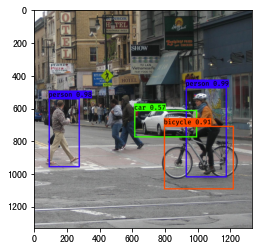

In [13]:
image = Image.open('street.jpg')  # 加载图像
r_image = detect_image(image)  # 使用YOLO模型进行对象检测
plt.imshow(r_image)  # 显示处理后的图